# Multilabel Chain Classification Model

## Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#DataViz
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split   #Perforing grid search
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier

#models
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.multioutput import ClassifierChain

from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
pd.options.display.max_columns = None

## Nulls

some bandwiths are nulls in all data because information about water absorption has been cleaned.

In [4]:
df = pd.read_csv('../data/GHISACONUS_2008_small.csv')
df.dropna(axis = 1, how = 'all', inplace= True)
df = df[df['Stage'] != 'Harvest']
df['Label'] = [','.join(i) for i in zip(df["Crop"],df["Stage"])]

features = [col for col in df.columns if col.startswith('X')]
X = df[features]
z = df['Label']
crop_ = df['Crop']
stage_ = df['Stage']

In [17]:
crop_labels = ['Corn', 'Cotton', 'Rice', 'Soybean', 'Winter Wheat']
stage_labels = ['Critical', 'Early_Mid', 'Emerge_VEarly',  'Late', 'Mature_Senesc']

### Creating Y

In [5]:
#Split dataset
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.15, random_state = 1, stratify=z)

#For the encoder
X_train, X_test, c_train, c_test = train_test_split(X, crop_, test_size = 0.15, random_state = 1, stratify=z)
X_train, X_test, s_train, s_test = train_test_split(X, stage_, test_size = 0.15, random_state = 1, stratify=z)

In [6]:
#Generate y_test
y_test = pd.DataFrame(z_test)

#split z_train 
y_test[['Crop','Stage']] = y_test['Label'].str.split(',',expand=True)

#Generate y_test 
y_train = pd.DataFrame(z_train)

#split z_train 
y_train[['Crop','Stage']] = y_train['Label'].str.split(',',expand=True)

encoder_crop = LabelEncoder()
encoder_crop.fit(crop_)

y_train['Crop'] = encoder_crop.transform(y_train['Crop'])
y_test['Crop'] = encoder_crop.transform(y_test['Crop'])

encoder_stage = LabelEncoder()
encoder_stage.fit(stage_)

y_train['Stage'] = encoder_stage.transform(y_train['Stage'])
y_test['Stage'] = encoder_stage.transform(y_test['Stage'])

y_train.drop(columns = ['Label'], inplace = True)
y_test.drop(columns = ['Label'], inplace = True)

In [7]:
y_train.head()

,Crop,Stage
879,4,4
3158,1,4
1919,0,1
1022,3,0
222,0,3


In [8]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((1015, 50), (1015, 2), (5747, 50), (5747, 2))

## Chain with LogReg

In [9]:
# initialize classifier chains multi-label classifier
chain = ClassifierChain(LogisticRegression(max_iter=100_000))
# Training logistic regression model on train data
chain.fit(X_train, y_train)

ClassifierChain(base_estimator=LogisticRegression(max_iter=100000))

In [51]:
# predict
predictions = chain.predict(X_test)
predictions = pd.DataFrame(predictions, columns=['Crop', 'Stage'])

predictions['Crop'] = predictions['Crop'].astype(int)
predictions['Stage'] = predictions['Stage'].astype(int)

predictions['Crop'] = encoder_crop.inverse_transform(predictions['Crop'])
predictions['Stage'] = encoder_stage.inverse_transform(predictions['Stage'])

crop_accuracy = accuracy_score(c_test, predictions['Crop'])
stage_accuracy = accuracy_score(s_test, predictions['Stage'])

print(f'Crop Accuracy: {round((crop_accuracy)*100, 2)}% -- Stage Accuracy: {round((stage_accuracy)*100, 2)}%')

Crop Accuracy: 61.87% -- Stage Accuracy: 76.06%


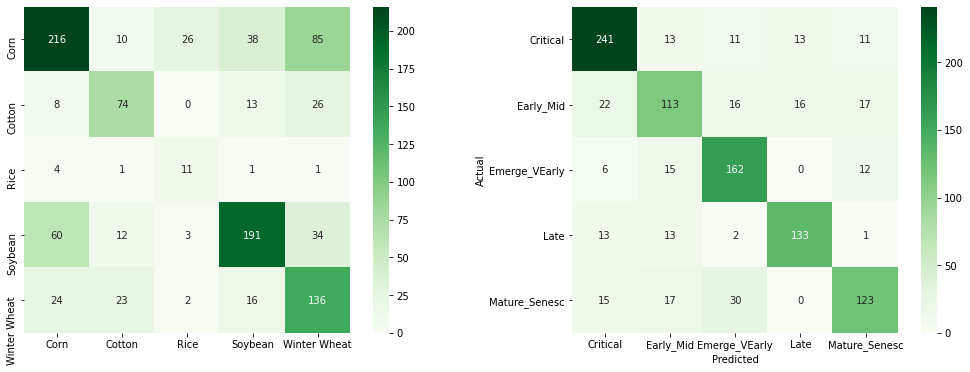

In [52]:
sns.light_palette("seagreen", as_cmap=True)
conf_mat_c = confusion_matrix(c_test, predictions['Crop'])
conf_mat_s = confusion_matrix(s_test, predictions['Stage'])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[18,6])

sns.heatmap(conf_mat_c, annot=True, fmt='d',
            xticklabels=crop_labels, yticklabels=crop_labels, square = True, ax= ax1, cmap='Greens', vmin = 0)

sns.heatmap(conf_mat_s, annot=True, fmt='d',
            xticklabels=stage_labels, yticklabels=stage_labels, square = True, ax = ax2, cmap='Greens', vmin = 0)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Gboost

In [49]:
gboost_class = GradientBoostingClassifier(n_estimators=100,
                                          learning_rate=1,
                                          max_depth=5,
                                          random_state=1)

# initialize classifier chains multi-label classifier
chain = ClassifierChain(gboost_class)
# Training logistic regression model on train data
chain.fit(X_train, y_train)

ClassifierChain(base_estimator=GradientBoostingClassifier(learning_rate=1,
                                                          max_depth=5,
                                                          random_state=1))

In [50]:
# predict
predictions = chain.predict(X_test)
predictions = pd.DataFrame(predictions, columns=['Crop', 'Stage'])

predictions['Crop'] = predictions['Crop'].astype(int)
predictions['Stage'] = predictions['Stage'].astype(int)

predictions['Crop'] = encoder_crop.inverse_transform(predictions['Crop'])
predictions['Stage'] = encoder_stage.inverse_transform(predictions['Stage'])

#Score Accuracy
crop_accuracy = accuracy_score(c_test, predictions['Crop'])
stage_accuracy = accuracy_score(s_test, predictions['Stage'])

print(f'Crop Accuracy: {round((crop_accuracy)*100, 2)}% -- Stage Accuracy: {round((stage_accuracy)*100, 2)}%')

Crop Accuracy: 61.87% -- Stage Accuracy: 76.06%


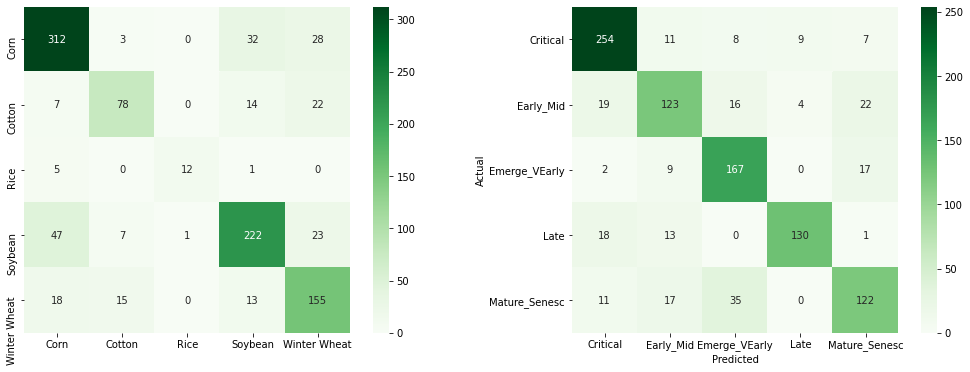

In [43]:
conf_mat_c = confusion_matrix(c_test, predictions['Crop'])
conf_mat_s = confusion_matrix(s_test, predictions['Stage'])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[18,6])

sns.heatmap(conf_mat_c, annot=True, fmt='d',
            xticklabels=crop_labels, yticklabels=crop_labels, square = True, ax= ax1, cmap = 'Greens', vmin= 0)

sns.heatmap(conf_mat_s, annot=True, fmt='d',
            xticklabels=stage_labels, yticklabels=stage_labels, square = True, ax = ax2, cmap = 'Greens', vmin= 0)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [64]:
y_true = y_test
y_true['Crop'] = encoder_crop.inverse_transform(y_true['Crop'])
y_true['Stage'] = encoder_stage.inverse_transform(y_true['Stage'])

In [65]:
index_test = y_test.reset_index()
index_test = index_test.rename(columns = {'index':'og_index'})
index_test['og_index']

0       2855
1       6936
2       5809
3       6672
4       3552
        ... 
1010      67
1011    3020
1012    5223
1013    2883
1014    4610
Name: og_index, Length: 1015, dtype: int64